## Machine Learning Engineering Career Track Capstone
    
### Step 6: Experiment With Various Models

The purpose of this step is for you to rigorously test how to build the best model for analyzing the patterns found in your dataset. 
Perform some of the following activities:
- Build an automated process to test many modeling techniques and ML algorithms with your data to see which one yields the best results
- Define the performance metric(s) best applied to your problem (accuracy, F1, RSME, LOC, etc.)
- Test various loss functions across models to see which one yields the best result
- Perform tuning of one or more model, across one or multiple hyperparameters
- Build a robust cross-validation process for your problem
- Ensemble multiple models together, and demonstrate the superior results
- Analyze the prediction results to confirm how some of your models ended up properly generalizing or overfitting the data
- Present your best model(s)

In [1]:
import os
import pickle
import sys
from random import sample
from time import time
from tempfile import mkdtemp
from shutil import rmtree

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, silhouette_score
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## Load checkpointed dataset 

containing extracted features

In [2]:
df = pd.read_pickle('data/features/df.pkl')

In [3]:
df.shape

(13700, 178)

In [4]:
df.extract_limit.head(1).values

array([110250])

In [5]:
df.dropna(inplace=True)
df.shape

(13700, 178)

In [6]:
y = df['emotion_class']
y.shape

(13700,)

In [9]:
# cannot use select_dtypes since I am using a scheme where features are stored under
# index *names* that are ints
X = df[(c for c in df.columns.values if isinstance(c, int))]
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,0.028367,0.763453,1.154009,1.324336,2.211738,0.878386,0.653164,0.659793,1.505851,3.910974,...,0.606857,0.570569,0.537492,0.586899,0.608427,0.66914,0.64631,0.688111,0.665084,0.682403


In [10]:
X.shape

(13700, 160)

In [11]:
y.value_counts().max() / y.value_counts().min()

17.96927374301676

Recapping, we have a 18x class label imbalance

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Experiment: Oversampling

As detailed in the previous notebook, there is class imbalance. Here I test various oversampling methods. Undersampling is not appropriate since we only have around 13K training examples. First get a simple baseline.

In [14]:
model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)
cv = round(np.mean(cv_scores), 4)
print(f'cv={cv}') 

cv=0.3037


In [15]:
model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
model.fit(X_train, y_train)
test = round(f1_score(y_test, model.predict(X_test), average='weighted'), 4)
print(f'test={test}')

test=0.3033


In [23]:
# SMOTE generates synthetic samples
oversample = SMOTE(random_state=0, n_jobs=-1)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_smote.shape, y_smote.shape

((36022, 160), (36022,))

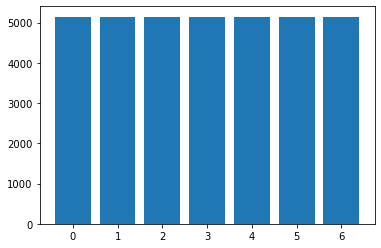

In [24]:
plt.bar(*np.unique(y_smote, return_counts=True));

This yields almost 3x the training data.

## Comparing oversampling techniques

Here let's use imblearn pipeline to search for the best oversampling technique for MELD dataset. Using the imblearn pipeline will avoid "data leakage" problem where replicated/duplicated data from the oversampling occurs in the train folds AND the test folds during CV.

ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, 
and its greatest advantages are not copying the same minority data, and generating  
more data for “harder to learn” examples.

SMOTETomek and SMOTEENN employ over- and under-sampling

In [27]:
from imblearn.pipeline import Pipeline 


pipe = Pipeline([
    ('sampler', None), 
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1))
])

params = [
    {'sampler': [ADASYN(random_state=0, n_jobs=-1)]},
    {'sampler': [SMOTE(random_state=0, n_jobs=-1)]},
    {'sampler': [SMOTETomek(random_state=0, n_jobs=-1)]},
    {'sampler': [SMOTEENN(random_state=0, n_jobs=-1)]},
]

search = GridSearchCV(pipe, params, scoring='f1_weighted', cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print('test=', search.score(X_test, y_test))

test= 0.30920056871487595


In [26]:
search.best_params_, search.best_score_

({'sampler': ADASYN(n_jobs=-1, random_state=0)}, 0.3150555069070049)

In [32]:
pd.DataFrame(search.cv_results_)[['param_sampler', 'mean_test_score', 'std_test_score']]

,param_sampler,mean_test_score,std_test_score
0,"ADASYN(n_jobs=-1, random_state=0)",0.315056,0.007987
1,"SMOTE(n_jobs=-1, random_state=0)",0.312405,0.005141
2,"SMOTETomek(n_jobs=-1, random_state=0)",0.313411,0.006464
3,"SMOTEENN(n_jobs=-1, random_state=0)",0.089702,0.003710


Looks like oversampling boosts F1 score by about 0.011 even when the classifier was taking class balance into account with class_weight='balanced'. ADASYN, SMOTE, and SMOTETomek achieve statistically equivalent performance among themselves but SMOTEENN was considerably worse.

## Experiment: Selecting Standardization

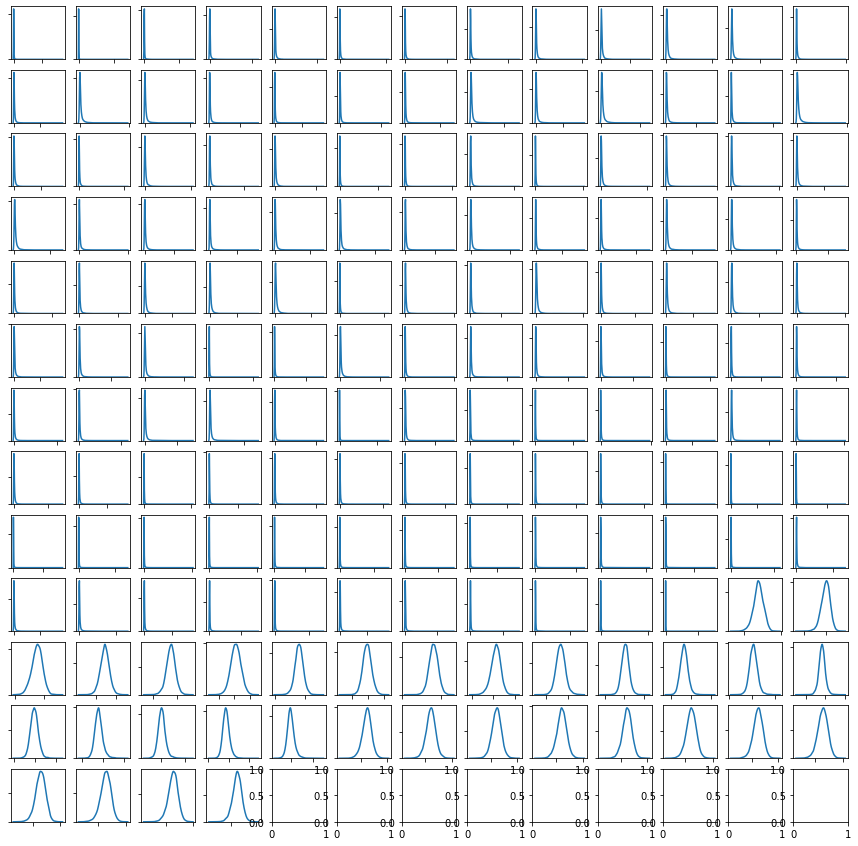

In [109]:
def plot_feat_distribs(X):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    sqrt = 13
    fig, axes = plt.subplots(nrows=sqrt, ncols=sqrt, figsize=(15,15))
    i, j = 0, 0
    for f in range(160):
        g = sns.kdeplot(data=X[:,f], ax=axes[i, j], legend=False, warn_singular=False)
        g.set(xticklabels=[])
        g.set(yticklabels=[])
        g.set(ylabel=None)
        j += 1
        if j == sqrt:
            i += 1
            j = 0
            
            
plot_feat_distribs(X)

In [85]:
from scipy.stats import shapiro, normaltest, anderson

res = [[normaltest(df[[f]]).pvalue[0], shapiro(df[[f]]).pvalue] for f in range(160)]
pd.DataFrame(res, columns=['normaltest', 'shapiro'])

/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,normaltest,shapiro
0,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00
...,...,...
155,2.389932e-53,2.724122e-20
156,4.744982e-64,2.400033e-22
157,1.838749e-82,2.021644e-25
158,1.125110e-79,3.318270e-25


None of the features are close Gaussian (> 0.05) but perhaps some preprocessing can transform them to be at least more Gaussian.

In [100]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

tf = QuantileTransformer(output_distribution='normal', random_state=0)
X_quant = tf.fit_transform(X)
X_quant.shape

(13700, 160)

In [93]:
def normality_report(X):
    res = [[normaltest(X[:,f]).pvalue, shapiro(X[:,f]).pvalue] for f in range(160)]
    return pd.DataFrame(res, columns=['normaltest', 'shapiro'])


quant_report = normality_report(X_quant)
quant_report.sample(10)

,normaltest,shapiro
12,0.725112,0.112777
129,0.495160,0.176002
27,0.559148,0.246491
151,0.348929,0.224321
137,0.712866,0.260237
30,0.537366,0.273925
62,0.584948,0.228144
125,0.002417,0.000006
144,0.691929,0.235511
143,0.773612,0.121385


OK, now we have some Gaussian feature distributions!

In [94]:
quant_report.describe()

,normaltest,shapiro
count,160.000000,160.000000
mean,0.519423,0.203242
std,0.177189,0.097269
min,0.000000,0.000000
25%,0.435459,0.149860
50%,0.545644,0.209901
75%,0.640442,0.265705
max,0.859847,0.406762


In [98]:
p = 0.05
(quant_report.normaltest < p).sum(), (quant_report.shapiro < p).sum()

(4, 17)

Depending on the test there are still 4 or 17 non-Gaussian features for Quantile transform.

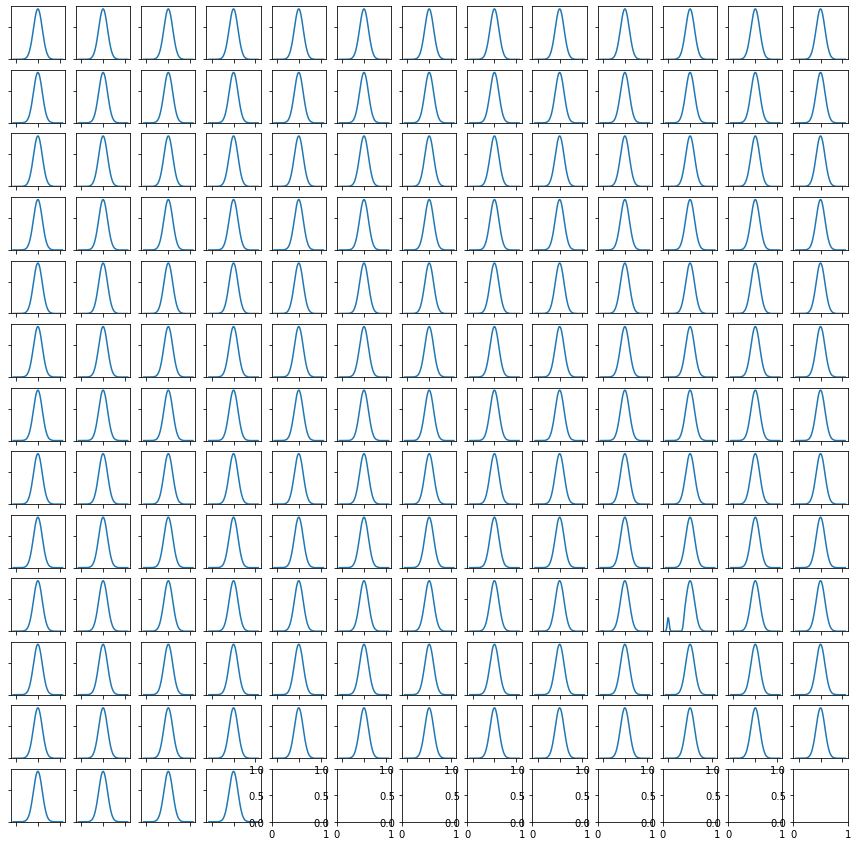

In [110]:
plot_feat_distribs(X_quant)

### PowerTransformer

In [107]:
tf = PowerTransformer()  # default to yeo-johnson, can't use box-cox due to negative values
X_yj = tf.fit_transform(X)
yj_report = normality_report(X_yj)
yj_report.sample(20)

/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,normaltest,shapiro
93,4.756669e-302,0.000000e+00
101,0.000000e+00,0.000000e+00
94,1.421191e-302,0.000000e+00
80,0.000000e+00,0.000000e+00
143,4.314583e-49,3.448734e-21
62,0.000000e+00,0.000000e+00
22,0.000000e+00,0.000000e+00
108,0.000000e+00,0.000000e+00
128,4.219891e-09,3.979151e-09
10,0.000000e+00,0.000000e+00


In [108]:
(yj_report.normaltest < p).sum(), (yj_report.shapiro < p).sum()

(160, 160)

None of the features are deemed Gaussian after Y-J transform, so it looks like quantile suits this situation well.

Does it help the vanilla RF classifier?

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_quant, y, test_size=0.2, stratify=y, random_state=0)
model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)
cv = round(np.mean(cv_scores), 4)
print(f'cv={cv}') 

cv=0.3037


In [112]:
model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
model.fit(X_train, y_train)
test = round(f1_score(y_test, model.predict(X_test), average='weighted'), 4)
print(f'test={test}')

test=0.3038


Performance is slightly better on the test set and the same on CV.

## Model selection 

In the last notebook I determined a good audio limit, extracted features based on that limit, and checkpointed the results. Here I continue to experiment with the next stages the ML pipeline.

In [55]:
def print_f1_weighted(pipe):
    train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
    devel_score = f1_score(y_dev, pipe.predict(X_dev), average='weighted')
    print('Train score: ', train_score)
    print('Devel score: ', devel_score)

In [56]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X_over, y_over)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])

In [57]:
def print_f1_weighted(pipe):
    train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
    devel_score = f1_score(y_dev, pipe.predict(X_dev), average='weighted')
    print('Train score: ', train_score)
    print('Devel score: ', devel_score)

In [58]:
print_f1_weighted(pipe)

Train score:  0.32003613391372937
Devel score:  0.09591415215376839


In [59]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X_over, y_over)

print_f1_weighted(pipe)

Train score:  0.32106962829883584
Devel score:  0.11130789804477417


Looks like StandardScaler yields slightly better performance.

## Experiment: PCA components

In [230]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=0)),
    ('estimator', RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1))
])

parameters = {
    'pca__n_components': list(range(1, 10)) + list(range(10, 161, 10)),  # total of 160 features
}

search = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.score(X_dev, y_dev)

0.27673701466165024

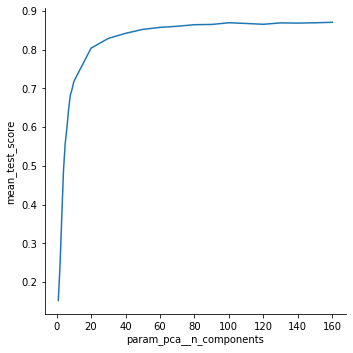

In [231]:
result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
sns.relplot(data=result_df, kind='line',
            x='param_pca__n_components',
            y='mean_test_score')
plt.show();

In [238]:
for param, score in zip(search.cv_results_['params'], search.cv_results_['mean_test_score']):
    print(list(param.values())[0], score)


1 0.15241729822150557
2 0.24245686805755
3 0.3667641116195962
4 0.48727578957823114
5 0.5572446618386353
6 0.5981900888399778
7 0.647100279068655
8 0.682904302301409
9 0.6981330818664324
10 0.7174978069673863
20 0.8038701244642551
30 0.8288912071065605
40 0.8420801879457155
50 0.8522141469884692
60 0.8574013393543265
70 0.8603090892423039
80 0.8643766348995117
90 0.865013905301576
100 0.8694074363430767
110 0.8675928859774341
120 0.8654319100547502
130 0.8690286934954974
140 0.8685211861019402
150 0.8693102831836775
160 0.8705789031781197


Doesn't really get better after 80 components.

## Comparing Models

In [239]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=80, random_state=0)),
    ('estimator', GaussianNB())  # this is just a placeholder so I can search over estimators
])

In [240]:
classifiers = [
    GaussianNB(),
    DecisionTreeClassifier(random_state=0, class_weight='balanced'),
    RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'),
    KNeighborsClassifier(n_jobs=-1),
    LinearSVC(multi_class='ovr', class_weight='balanced', random_state=0),
    LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=0, max_iter=1000, 
                       n_jobs=-1),  
    LogisticRegression(multi_class='ovr', class_weight='balanced', random_state=0, max_iter=1000, n_jobs=-1),   
    MLPClassifier(random_state=0),
    RidgeClassifier(class_weight='balanced', random_state=0)
]

parameters = [{'estimator': [clf]} for clf in classifiers]
search = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)

search.fit(X_train, y_train)

search.best_params_

{'estimator': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)}

In [241]:
tmp = zip([str(x['estimator']) for x in search.cv_results_['params']], search.cv_results_['mean_test_score'])
res_df = pd.DataFrame(tmp, columns=["Model", "F1-weighted train"])
res_df.sort_values('F1-weighted train', ascending=False)

,Model,F1-weighted train
2,RandomForestClassifier(class_weight='balanced'...,0.864691
3,KNeighborsClassifier(n_jobs=-1),0.724363
7,MLPClassifier(random_state=0),0.613828
1,DecisionTreeClassifier(class_weight='balanced'...,0.580205
5,"LogisticRegression(class_weight='balanced', ma...",0.223648
8,"RidgeClassifier(class_weight='balanced', rando...",0.219893
4,"LinearSVC(class_weight='balanced', random_stat...",0.219705
6,"LogisticRegression(class_weight='balanced', ma...",0.215513
0,GaussianNB(),0.114682


In [242]:
search.score(X_dev, y_dev)

0.28519597622070914

/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

Looks like the MLP, KNN, and RF classifiers had best performance without any hyperparameter optimization. The RF score on the dev set was ~0.285

### Optimizing MLPClassifier

In [204]:
base_mlp = MLPClassifier(random_state=0)
base_mlp.hidden_layer_sizes, clf.alpha, clf.learning_rate

((100,), 0.0001, 'constant')

Be sure to include the default values in the grid search

In [157]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', MLPClassifier(random_state=0, max_iter=2000))
])

parameters = {
    'estimator__hidden_layer_sizes': [100, 105, 110, 115, 120, 125, 130],
    'estimator__alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],  # L2 penalty (regularization term)
    'estimator__learning_rate': ['constant', 'invscaling', 'adaptive']
}

search_mlp = GridSearchCV(
    pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1
).fit(X_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


In [166]:
print('Train score: ', search_mlp.score(X_train, y_train))
print('Dev score: ', search_mlp.score(X_dev, y_dev))

Train score:  0.3060811545527449
Dev score:  0.2599004344917845


In [177]:
def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)

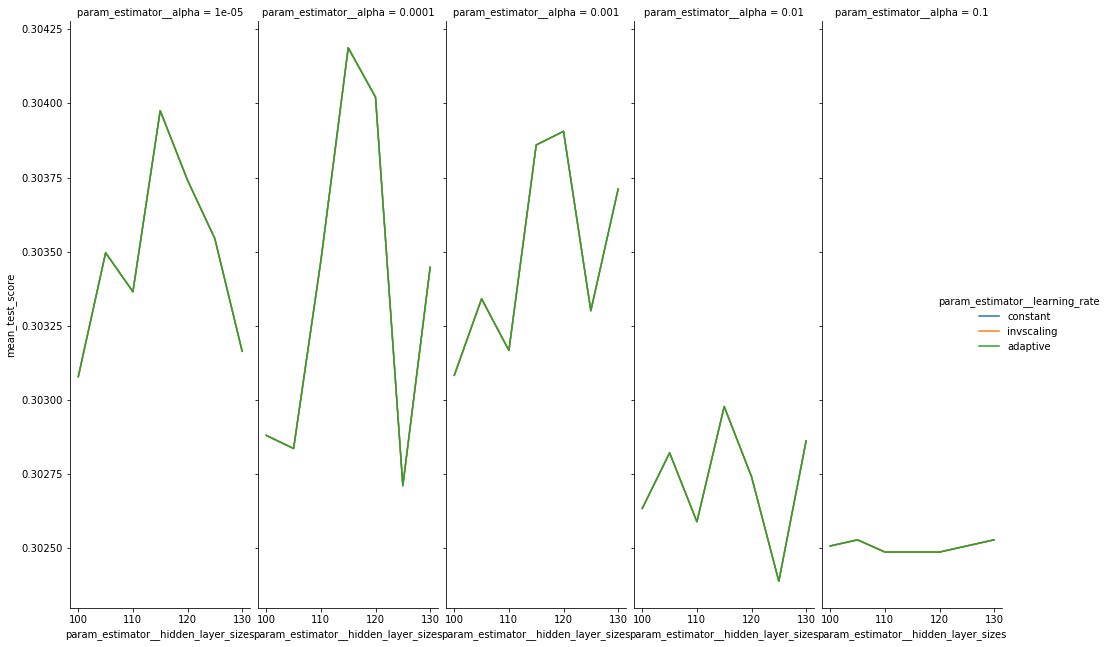

In [178]:
grid_search_plot(search_mlp, 
                 'estimator__hidden_layer_sizes', col='estimator__alpha', hue='estimator__learning_rate')

Learning rate does not have much effect, alpha is good around default value of 0.0001, and hidden units seems best around 115.

In [179]:
parameters = {
    'estimator__hidden_layer_sizes': list(range(110, 121)),
    'estimator__alpha': np.linspace(0.0001, 0.00001, 10),  # L2 penalty (regularization term)
}

search_mlp = GridSearchCV(
    pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1
).fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


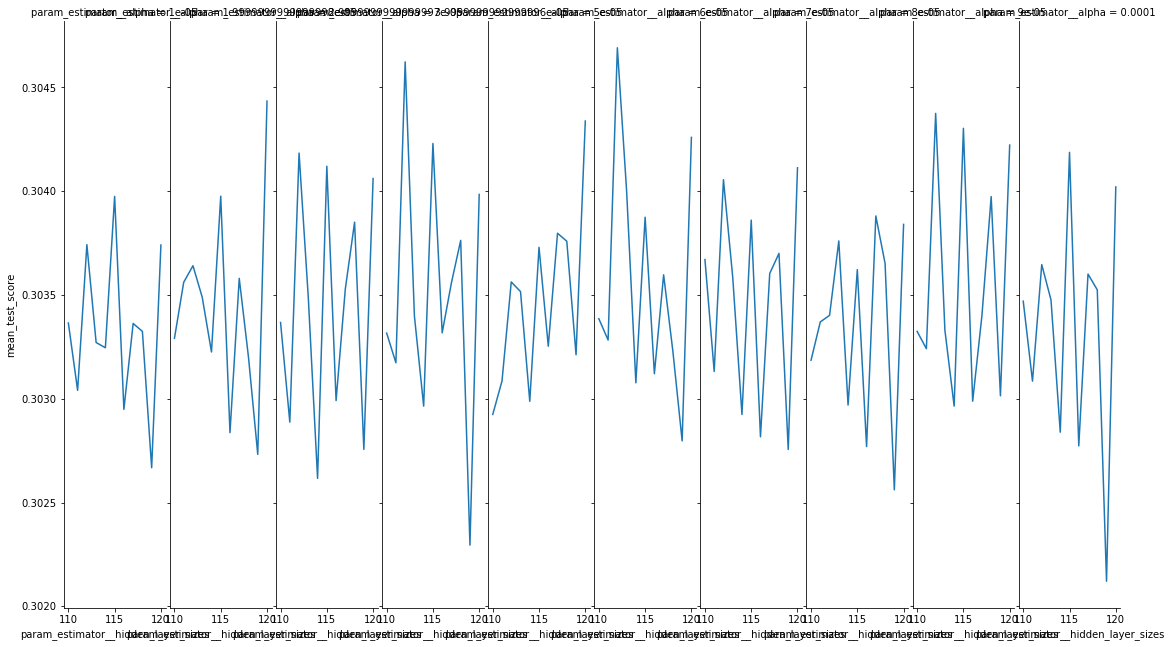

In [183]:
grid_search_plot(search_mlp, x='estimator__hidden_layer_sizes', col='estimator__alpha')

There doesn't appear to be a discernable pattern here, so I'll take the best estimator and compare it to baseline.

In [185]:
print(search_mlp.best_estimator_)
print(search_mlp.best_params_)
print('Train score: ', search_mlp.score(X_train, y_train))
print('Dev score: ', search_mlp.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 MLPClassifier(alpha=6e-05, hidden_layer_sizes=112,
                               max_iter=2000, random_state=0))])
{'estimator__alpha': 6e-05, 'estimator__hidden_layer_sizes': 112}
Train score:  0.3044336666871381
Dev score:  0.25736382777584715


The MLP baseline train score was 0.302902, so I've slightly improved that with the hyperparameter optimization.
The dev score baseline is as follows:

In [209]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', MLPClassifier(random_state=0, max_iter=2000))
])


pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2580852002445182

Performance on the dev set is slightly worse for the hyperparameter-optimized model than the default MLP model.

### Optimizing KNeighborsClassifier

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': list(range(1, 11)),
    'estimator__weights': ['uniform', 'distance'],
    # p = 1, equivalent to using manhattan_distance (l1), 
    # For arbitrary p, minkowski_distance (l_p) is used.
    'estimator__p': list(range(1, 11)),
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

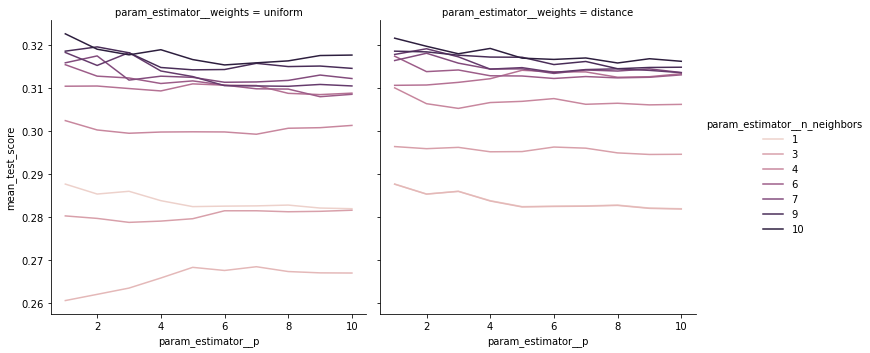

<Figure size 1280x960 with 0 Axes>

In [150]:
grid_search_plot(search_knn, hue='estimator__n_neighbors', x='estimator__p', col='estimator__weights')

Looks like increasing p slightly worsens results, so we can fix that to 1. N_neighbors definitely improves performance. 

In [151]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': list(range(11, 21)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__p': [1],
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

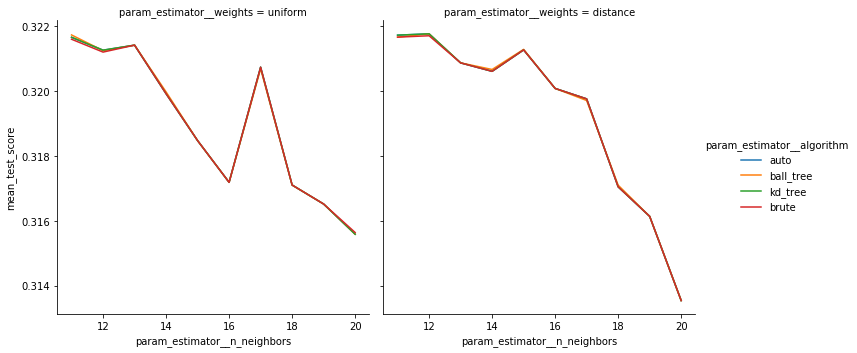

<Figure size 1280x960 with 0 Axes>

In [154]:
grid_search_plot(search_knn, x='estimator__n_neighbors', hue='estimator__algorithm', col='estimator__weights');

Looks like n_neighbors peaks around 11-12 and the algorithm has little effect.

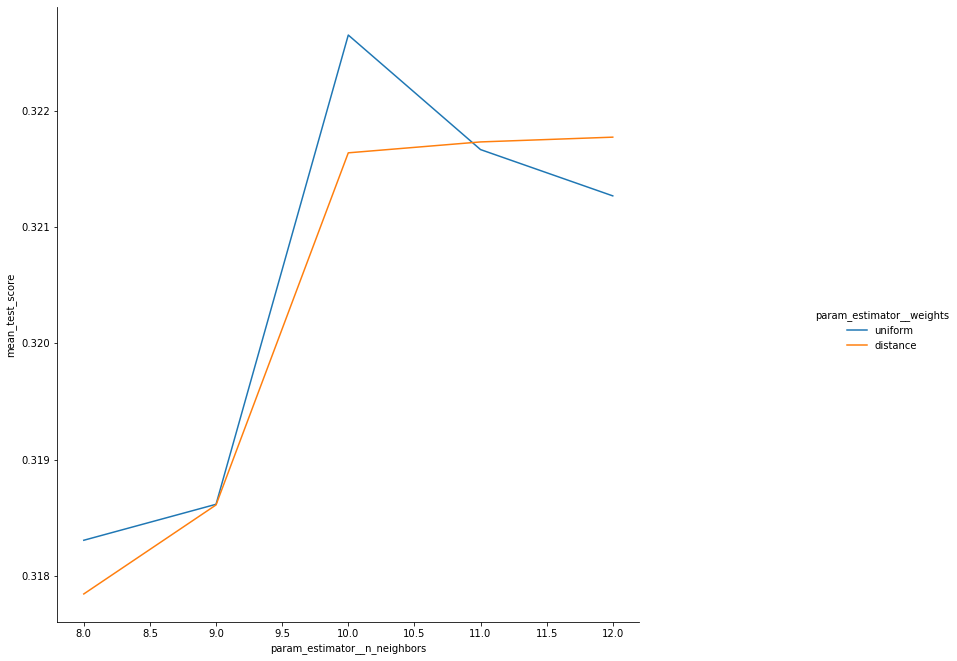

In [207]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': [8, 9, 10, 11, 12],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1],
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)
grid_search_plot(search_knn, x='estimator__n_neighbors', hue='estimator__weights')

Looks like the best hyperparams are p=1, weights=uniform, n_neighbors=10

In [208]:
print(search_knn.best_estimator_)
print(search_knn.best_params_)
print('Train score: ', search_knn.score(X_train, y_train))
print('Dev score: ', search_knn.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=10, p=1))])
{'estimator__n_neighbors': 10, 'estimator__p': 1, 'estimator__weights': 'uniform'}
Train score:  0.40890122166136206
Dev score:  0.2952544287092447


Comparison with unoptimized KNN clf...

In [210]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2863050675215029

I was able to improve the KNN classifier perf on the dev set using hyperparameter search. Also the KNN perf is superceding that of the MLP classifier.

### Optimizing RandomForestClassifier

Finally, here I will try optimizing RF which was number 1 in the initial naive assessment.

In [243]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'))
])

parameters = {
    'estimator__n_estimators': list(range(80, 121, 10)),
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
}

search_rf = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

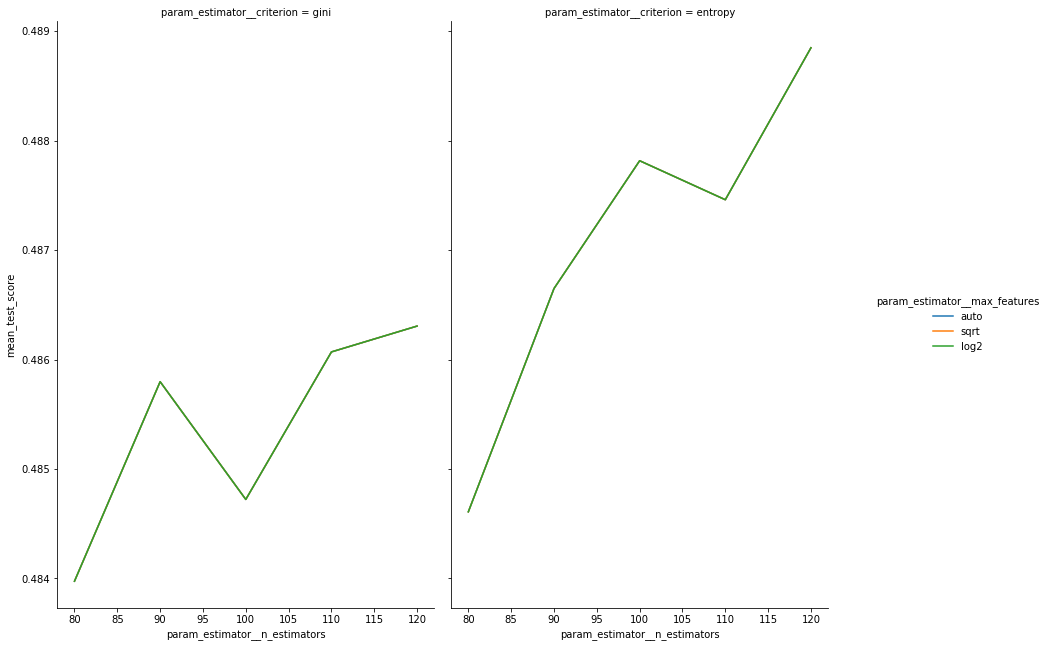

In [244]:
grid_search_plot(search_rf, x='estimator__n_estimators', hue='estimator__max_features', col='estimator__criterion')

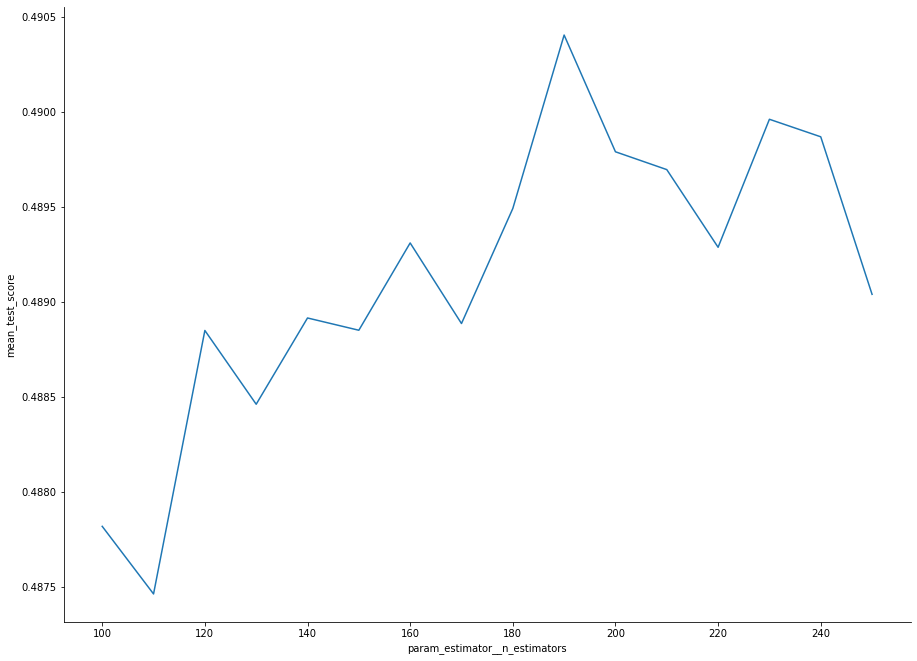

In [245]:
parameters = {
    'estimator__n_estimators': list(range(100, 251, 10)),
    'estimator__criterion': ['entropy'],
}

search_rf = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

grid_search_plot(search_rf, x='estimator__n_estimators')

In [247]:
print(search_rf.best_estimator_)
print(search_rf.best_params_)
print('Train score: ', search_rf.score(X_train, y_train))
print('Dev score: ', search_rf.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', n_estimators=190,
                                        n_jobs=-1, random_state=0))])
{'estimator__criterion': 'entropy', 'estimator__n_estimators': 190}
Train score:  0.9994841445754338
Dev score:  0.19468963393307823


In [40]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'))
])

pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2714765081882874

In [41]:
f1_score(y_test, pipe.predict(X_test), average='weighted')

0.3233998051438414

## XGBoost, LightGBM

Since RandomForests did well, I am curious to try the vaunted gradient boosting approaches. Also, the powerful temporal DNN LSTM is an interesting exploration.

In [7]:
import xgboost as xgb

xgb.__version__

'1.5.0'

In [16]:
%%time
clf = xgb.XGBClassifier()
scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)
cv = np.mean(scores)
print(f'cv={cv:.4f}') 

cv=0.3303
CPU times: user 68.4 ms, sys: 254 ms, total: 322 ms
Wall time: 3min 23s
[11:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
import lightgbm as lgb
lgb.__version__

'3.2.1'

In [19]:
%%time
clf = lgb.LGBMClassifier()
scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)
cv = np.mean(scores)
print(f'cv={cv:.4f}') 

cv=0.3204
CPU times: user 54.9 ms, sys: 189 ms, total: 244 ms
Wall time: 16.6 s


LGBM trains faster but XGBoost gave better perf. Now I want to play around with sk-optimize on LGBM..

In [28]:
import skopt


skopt.__version__

'0.9.0'

In [46]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import TimerCallback, DeadlineStopper

# https://lightgbm.readthedocs.io/en/v3.2.1/pythonapi/lightgbm.LGBMClassifier.html
search_spaces = {
        'boosting_type': Categorical(['gbdt', 'dart', 'goss']),               # def=gbdt
        'num_leaves': Integer(10, 100),                                       # def=31
        'max_depth': Integer(1, 20),                                          # def=-1 no limit
        'learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
        'n_estimators': Integer(low=50, high=500),                            # def=100    
        'min_split_gain': Real(0.0, 1.0),                                     # def=0
        'min_child_weight': Real(low=0.00001, high=0.1, prior='log-uniform'), # def=1e-3
        'min_child_samples': Integer(10, 30),                                 # def=20
#         'reg_alpha': Integer(0, 100),                                         # def=0
#         'reg_lambda': Integer(0, 100),                                        # def=0
        
#         'subsample': [1.0],
#         'subsample_freq': [0],
#         'colsample_bytree': [1],
    }

In [47]:
%%time
n_iter = 50 * 6
budget_minutes = 120

cbs = [TimerCallback(), DeadlineStopper(60 * budget_minutes)]
opt = BayesSearchCV(
    lgb.LGBMClassifier(objective='multiclass', class_weight='balanced'),
    search_spaces=search_spaces,
    scoring='f1_weighted',
    n_jobs=-1,
    n_points=1,  # number of parameter settings to sample in parallel
    n_iter=n_iter,
    refit=True,  # after opt, refits on entire dataset, so predictions can be made
    verbose=10,
    cv=3
)

opt.fit(X_train, y_train, callback=cbs)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81 
[CV]  boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81, score=0.336, total=  15.4s
[CV] boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81 
[CV]  boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81, score=0.326, total=  15.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43 
[CV]  boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43, score=0.330, total=  25.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.16804620375253496, max_depth=15, min_child_samples=29, min_child_weight=8.171547471428916e-05, min_split_gain=0.1327595183898577, n_estimators=303, num_leaves=96 
[CV]  boosting_type=goss, learning_rate=0.16804620375253496, max_depth=15, min_child_samples=29, min_child_weight=8.171547471428916e-05, min_split_gain=0.1327595183898577, n_estimators=303, num_leaves=96, score=0.328, total=  16.6s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.00315293045309079, max_depth=3, min_child_samples=11, min_child_weight=0.0001129602803850406, min_split_gain=0.8909059935909068, n_estimators=204, num_leaves=37 
[CV]  boosting_type=goss, learning_rate=0.00315293045309079, max_depth=3, min_child_samples=11, min_child_weight=0.0001129602803850406, min_split_gain=0.8909059935909068, n_estimators=204, num_leaves=37, score=0.170, total=   7.2s
[CV] boosting_type=gbdt, learning_rate=0.011912538865186235, max_depth=9, min_child_samples=13, min_child_weight=7.262624992323683e-05, min_split_gain=0.04158564569442192, n_estimators=314, num_leaves=67 
[CV]  boosting_type=gbdt, learning_rate=0.011912538865186235, max_depth=9, min_child_samples=13, min_child_weight=7.262624992323683e-05, min_split_gain=0.04158564569442192, n_estimators=314, num_leaves=67, score=0.332, total= 1.2min
[CV] boosting_type=goss, learning_rate=0.006580354882990159, max_depth=4, min_child_samples=13, min_child_weight=3.1558029136731

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.0s finished


[CV] boosting_type=gbdt, learning_rate=0.011912538865186235, max_depth=9, min_child_samples=13, min_child_weight=7.262624992323683e-05, min_split_gain=0.04158564569442192, n_estimators=314, num_leaves=67 
[CV]  boosting_type=gbdt, learning_rate=0.011912538865186235, max_depth=9, min_child_samples=13, min_child_weight=7.262624992323683e-05, min_split_gain=0.04158564569442192, n_estimators=314, num_leaves=67, score=0.328, total= 1.2min
[CV] boosting_type=goss, learning_rate=0.008946306745492419, max_depth=10, min_child_samples=20, min_child_weight=0.00011117687791635986, min_split_gain=0.13527230185916367, n_estimators=253, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.008946306745492419, max_depth=10, min_child_samples=20, min_child_weight=0.00011117687791635986, min_split_gain=0.13527230185916367, n_estimators=253, num_leaves=10, score=0.226, total=  10.8s
[CV] boosting_type=gbdt, learning_rate=0.022394409181309045, max_depth=16, min_child_samples=15, min_child_weight=0.0035

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.16804620375253496, max_depth=15, min_child_samples=29, min_child_weight=8.171547471428916e-05, min_split_gain=0.1327595183898577, n_estimators=303, num_leaves=96 
[CV]  boosting_type=goss, learning_rate=0.16804620375253496, max_depth=15, min_child_samples=29, min_child_weight=8.171547471428916e-05, min_split_gain=0.1327595183898577, n_estimators=303, num_leaves=96, score=0.335, total=  16.5s
[CV] boosting_type=gbdt, learning_rate=0.0035318143130009466, max_depth=19, min_child_samples=24, min_child_weight=2.8392654407052468e-05, min_split_gain=0.20761123810027843, n_estimators=388, num_leaves=67 
[CV]  boosting_type=gbdt, learning_rate=0.0035318143130009466, max_depth=19, min_child_samples=24, min_child_weight=2.8392654407052468e-05, min_split_gain=0.20761123810027843, n_estimators=388, num_leaves=67, score=0.317, total= 1.6min
[CV] boosting_type=goss, learning_rate=0.005454034285790761, max_depth=12, min_child_samples=10, min_child_weight=0.0027

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.0033616746678768327, max_depth=15, min_child_samples=23, min_child_weight=0.03483761315532849, min_split_gain=0.27647480296574606, n_estimators=367, num_leaves=14 
[CV]  boosting_type=gbdt, learning_rate=0.0033616746678768327, max_depth=15, min_child_samples=23, min_child_weight=0.03483761315532849, min_split_gain=0.27647480296574606, n_estimators=367, num_leaves=14, score=0.242, total=  24.2s
[CV] boosting_type=gbdt, learning_rate=0.0031105799178918077, max_depth=12, min_child_samples=14, min_child_weight=0.003060775256210362, min_split_gain=0.7454950998459831, n_estimators=195, num_leaves=78 
[CV]  boosting_type=gbdt, learning_rate=0.0031105799178918077, max_depth=12, min_child_samples=14, min_child_weight=0.003060775256210362, min_split_gain=0.7454950998459831, n_estimators=195, num_leaves=78, score=0.280, total=  49.1s
[CV] boosting_type=goss, learning_rate=0.005454034285790761, max_depth=12, min_child_samples=10, min_child_weight=0.00270641

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.05563369656656222, max_depth=12, min_child_samples=12, min_child_weight=0.0004137992374742509, min_split_gain=0.9854691271988205, n_estimators=97, num_leaves=74 
[CV]  boosting_type=gbdt, learning_rate=0.05563369656656222, max_depth=12, min_child_samples=12, min_child_weight=0.0004137992374742509, min_split_gain=0.9854691271988205, n_estimators=97, num_leaves=74, score=0.325, total=   9.0s
[CV] boosting_type=gbdt, learning_rate=0.001, max_depth=18, min_child_samples=10, min_child_weight=0.0044609031270075915, min_split_gain=0.4994967291296629, n_estimators=453, num_leaves=83 
[CV]  boosting_type=gbdt, learning_rate=0.001, max_depth=18, min_child_samples=10, min_child_weight=0.0044609031270075915, min_split_gain=0.4994967291296629, n_estimators=453, num_leaves=83, score=0.273, total= 2.6min
[CV] boosting_type=gbdt, learning_rate=0.06796388655599832, max_depth=12, min_child_samples=11, min_child_weight=0.1, min_split_gain=0.9822185480643169, n_est

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43 
[CV]  boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43, score=0.330, total=  25.2s
[CV] boosting_type=gbdt, learning_rate=0.0031105799178918077, max_depth=12, min_child_samples=14, min_child_weight=0.003060775256210362, min_split_gain=0.7454950998459831, n_estimators=195, num_leaves=78 
[CV]  boosting_type=gbdt, learning_rate=0.0031105799178918077, max_depth=12, min_child_samples=14, min_child_weight=0.003060775256210362, min_split_gain=0.7454950998459831, n_estimators=195, num_leaves=78, score=0.285, total=  49.5s
[CV] boosting_type=gbdt, learning_rate=0.0035318143130009466, max_depth=19, min_child_samples=24, min_child_weight=2.83926544070

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.337, total= 2.0min
[CV] boosting_type=dart, learning_rate=0.12168697221130269, max_depth=14, min_child_samples=12, min_child_weight=0.03191749445203487, min_split_gain=0.8158955296737459, n_estimators=500, num_leaves=59 
[CV]  boosting_type=dart, learning_rate=0.12168697221130269, max_depth=14, min_child_samples=12, min_child_weight=0.03191749445203487, min_split_gain=0.8158955296737459, n_estimators=500, num_leaves=59, score=0.331, total= 1.0min
[CV] boosting_type=dart, learning_rate=0.12786116261037278, max_depth=14, min_child_samples=29, min_child_weight=0.1, min_split_gain=0.07274902144905415, n_estimators=111, num_leaves=100 
[CV]  bo

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81 
[CV]  boosting_type=goss, learning_rate=0.077373027898502, max_depth=18, min_child_samples=12, min_child_weight=0.0012471205794141085, min_split_gain=0.6783541563838973, n_estimators=103, num_leaves=81, score=0.331, total=  15.5s
[CV] boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43 
[CV]  boosting_type=gbdt, learning_rate=0.025771542416562623, max_depth=13, min_child_samples=12, min_child_weight=0.05080845695337209, min_split_gain=0.7206588366938045, n_estimators=438, num_leaves=43, score=0.338, total=  24.8s
[CV] boosting_type=gbdt, learning_rate=0.0035318143130009466, max_depth=19, min_child_samples=24, min_child_weight=2.8392654407052468e

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.001, max_depth=20, min_child_samples=30, min_child_weight=3.5269839003353646e-05, min_split_gain=0.17829275895663418, n_estimators=469, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.001, max_depth=20, min_child_samples=30, min_child_weight=3.5269839003353646e-05, min_split_gain=0.17829275895663418, n_estimators=469, num_leaves=100, score=0.240, total= 3.6min
[CV] boosting_type=dart, learning_rate=0.21984192493362323, max_depth=18, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.774978091436278, n_estimators=500, num_leaves=66 
[CV]  boosting_type=dart, learning_rate=0.21984192493362323, max_depth=18, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.774978091436278, n_estimators=500, num_leaves=66, score=0.332, total=  46.5s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.06063256475197012, min_split_gain=0.1637737194324805, n_estimators=247, num_leaves=10 
[CV]  boosting_type=gbdt, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.06063256475197012, min_split_gain=0.1637737194324805, n_estimators=247, num_leaves=10, score=0.325, total=   6.5s
[CV] boosting_type=dart, learning_rate=0.021411470109020964, max_depth=8, min_child_samples=10, min_child_weight=0.034854762600159114, min_split_gain=0.8335555899474175, n_estimators=315, num_leaves=74 
[CV]  boosting_type=dart, learning_rate=0.021411470109020964, max_depth=8, min_child_samples=10, min_child_weight=0.034854762600159114, min_split_gain=0.8335555899474175, n_estimators=315, num_leaves=74, score=0.321, total= 1.2min
[CV] boosting_type=dart, learning_rate=0.016520773069281253, max_depth=13, min_child_samples=15, min_child_weight=0.000110280093857422

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.0033616746678768327, max_depth=15, min_child_samples=23, min_child_weight=0.03483761315532849, min_split_gain=0.27647480296574606, n_estimators=367, num_leaves=14 
[CV]  boosting_type=gbdt, learning_rate=0.0033616746678768327, max_depth=15, min_child_samples=23, min_child_weight=0.03483761315532849, min_split_gain=0.27647480296574606, n_estimators=367, num_leaves=14, score=0.221, total=  24.3s
[CV] boosting_type=goss, learning_rate=0.00315293045309079, max_depth=3, min_child_samples=11, min_child_weight=0.0001129602803850406, min_split_gain=0.8909059935909068, n_estimators=204, num_leaves=37 
[CV]  boosting_type=goss, learning_rate=0.00315293045309079, max_depth=3, min_child_samples=11, min_child_weight=0.0001129602803850406, min_split_gain=0.8909059935909068, n_estimators=204, num_leaves=37, score=0.182, total=   7.1s
[CV] boosting_type=goss, learning_rate=0.006580354882990159, max_depth=4, min_child_samples=13, min_child_weight=3.1558029136731

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.004220103939724679, max_depth=20, min_child_samples=20, min_child_weight=3.7859273498358283e-05, min_split_gain=0.9363444880437582, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.004220103939724679, max_depth=20, min_child_samples=20, min_child_weight=3.7859273498358283e-05, min_split_gain=0.9363444880437582, n_estimators=500, num_leaves=100, score=0.296, total= 3.9min
[CV] boosting_type=goss, learning_rate=0.09971490657946022, max_depth=15, min_child_samples=10, min_child_weight=0.0005015756511023172, min_split_gain=0.38057404546691104, n_estimators=263, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.09971490657946022, max_depth=15, min_child_samples=10, min_child_weight=0.0005015756511023172, min_split_gain=0.38057404546691104, n_estimators=263, num_leaves=100, score=0.340, total=  21.0s
[CV] boosting_type=gbdt, learning_rate=0.008069850179224354, max_depth=8, min_child_samples=21, min_child_weight=0.000

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.06063256475197012, min_split_gain=0.1637737194324805, n_estimators=247, num_leaves=10 
[CV]  boosting_type=gbdt, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.06063256475197012, min_split_gain=0.1637737194324805, n_estimators=247, num_leaves=10, score=0.323, total=   6.5s
[CV] boosting_type=dart, learning_rate=0.02345758910159452, max_depth=17, min_child_samples=25, min_child_weight=0.015252746554468613, min_split_gain=0.3048513965928795, n_estimators=50, num_leaves=39 
[CV]  boosting_type=dart, learning_rate=0.02345758910159452, max_depth=17, min_child_samples=25, min_child_weight=0.015252746554468613, min_split_gain=0.3048513965928795, n_estimators=50, num_leaves=39, score=0.268, total=   9.2s
[CV] boosting_type=goss, learning_rate=0.49999999999999994, max_depth=10, min_child_samples=22, min_child_weight=1e-05, min_split_gain=0

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.1113534809097135, max_depth=15, min_child_samples=30, min_child_weight=0.00592558153773413, min_split_gain=0.18333294474307651, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.1113534809097135, max_depth=15, min_child_samples=30, min_child_weight=0.00592558153773413, min_split_gain=0.18333294474307651, n_estimators=500, num_leaves=100, score=0.338, total=  23.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.008069850179224354, max_depth=8, min_child_samples=21, min_child_weight=0.0003605212788104992, min_split_gain=0.06678398300445315, n_estimators=500, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.008069850179224354, max_depth=8, min_child_samples=21, min_child_weight=0.0003605212788104992, min_split_gain=0.06678398300445315, n_estimators=500, num_leaves=100, score=0.330, total= 1.5min
[CV] boosting_type=dart, learning_rate=0.04159501455165257, max_depth=16, min_child_samples=10, min_child_weight=0.00025763300553197685, min_split_gain=1.0, n_estimators=500, num_leaves=66 
[CV]  boosting_type=dart, learning_rate=0.04159501455165257, max_depth=16, min_child_samples=10, min_child_weight=0.00025763300553197685, min_split_gain=1.0, n_estimators=500, num_leaves=66, score=0.334, total= 1.5min
[CV] boosting_type=goss, learning_rate=0.050905143960897174, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=1.0, n_estimator

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.00918515213104649, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.2734408109029522, n_estimators=500, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.00918515213104649, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.2734408109029522, n_estimators=500, num_leaves=100, score=0.336, total= 2.0min
[CV] boosting_type=goss, learning_rate=0.1113534809097135, max_depth=15, min_child_samples=30, min_child_weight=0.00592558153773413, min_split_gain=0.18333294474307651, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.1113534809097135, max_depth=15, min_child_samples=30, min_child_weight=0.00592558153773413, min_split_gain=0.18333294474307651, n_estimators=500, num_leaves=100, score=0.331, total=  23.0s
[CV] boosting_type=goss, learning_rate=0.010684387526905162, max_depth=16, min_child_samples=10, min_child_weight=0.00021086154968313268, min_split_gain=0.97356

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.0179246759788998, max_depth=13, min_child_samples=13, min_child_weight=0.1, min_split_gain=0.42641825033823055, n_estimators=231, num_leaves=71 
[CV]  boosting_type=dart, learning_rate=0.0179246759788998, max_depth=13, min_child_samples=13, min_child_weight=0.1, min_split_gain=0.42641825033823055, n_estimators=231, num_leaves=71, score=0.310, total= 1.4min
[CV] boosting_type=gbdt, learning_rate=0.017742834100854473, max_depth=12, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.17324756380190254, n_estimators=500, num_leaves=73 
[CV]  boosting_type=gbdt, learning_rate=0.017742834100854473, max_depth=12, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.17324756380190254, n_estimators=500, num_leaves=73, score=0.334, total= 1.5min
[CV] boosting_type=dart, learning_rate=0.04159501455165257, max_depth=16, min_child_samples=10, min_child_weight=0.00025763300553197685, min_split_gain=1.0, n_estimators=500, num_leaves=66 
[C

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.01969658180361769, max_depth=20, min_child_samples=10, min_child_weight=0.061833628016012096, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.01969658180361769, max_depth=20, min_child_samples=10, min_child_weight=0.061833628016012096, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.337, total= 2.5min
[CV] boosting_type=goss, learning_rate=0.00841108046784256, max_depth=14, min_child_samples=30, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.00841108046784256, max_depth=14, min_child_samples=30, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.332, total= 1.4min
[CV] boosting_type=goss, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.49999

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.10309388395261003, max_depth=15, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=10 
[CV]  boosting_type=gbdt, learning_rate=0.10309388395261003, max_depth=15, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=10, score=0.309, total=   9.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.12409700042443922, max_depth=16, min_child_samples=24, min_child_weight=0.1, min_split_gain=0.8552227212518863, n_estimators=50, num_leaves=92 
[CV]  boosting_type=dart, learning_rate=0.12409700042443922, max_depth=16, min_child_samples=24, min_child_weight=0.1, min_split_gain=0.8552227212518863, n_estimators=50, num_leaves=92, score=0.330, total=   5.8s
[CV] boosting_type=gbdt, learning_rate=0.00918515213104649, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.2734408109029522, n_estimators=500, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.00918515213104649, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.2734408109029522, n_estimators=500, num_leaves=100, score=0.337, total= 2.0min
[CV] boosting_type=goss, learning_rate=0.11006778793413136, max_depth=14, min_child_samples=30, min_child_weight=1.954804861121693e-05, min_split_gain=0.0, n_estimators=94, num_leaves=83 
[CV]  bo

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.1623396729376777, max_depth=16, min_child_samples=23, min_child_weight=2.6359524505202206e-05, min_split_gain=0.0, n_estimators=336, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.1623396729376777, max_depth=16, min_child_samples=23, min_child_weight=2.6359524505202206e-05, min_split_gain=0.0, n_estimators=336, num_leaves=100, score=0.318, total= 2.1min
[CV] boosting_type=gbdt, learning_rate=0.30688614551709603, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=50, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.30688614551709603, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=50, num_leaves=100, score=0.334, total=  13.2s
[CV] boosting_type=dart, learning_rate=0.001, max_depth=1, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.001, max_depth=1, min

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.09971490657946022, max_depth=15, min_child_samples=10, min_child_weight=0.0005015756511023172, min_split_gain=0.38057404546691104, n_estimators=263, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.09971490657946022, max_depth=15, min_child_samples=10, min_child_weight=0.0005015756511023172, min_split_gain=0.38057404546691104, n_estimators=263, num_leaves=100, score=0.340, total=  21.2s
[CV] boosting_type=gbdt, learning_rate=0.017742834100854473, max_depth=12, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.17324756380190254, n_estimators=500, num_leaves=73 
[CV]  boosting_type=gbdt, learning_rate=0.017742834100854473, max_depth=12, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.17324756380190254, n_estimators=500, num_leaves=73, score=0.344, total= 1.4min
[CV] boosting_type=gbdt, learning_rate=0.02391770995896085, max_depth=12, min_child_samples=16, min_child_weight=0.0031140192104064015, min_split_gain=0

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.23973057651789348, max_depth=16, min_child_samples=10, min_child_weight=0.049206886443358876, min_split_gain=1.0, n_estimators=50, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.23973057651789348, max_depth=16, min_child_samples=10, min_child_weight=0.049206886443358876, min_split_gain=1.0, n_estimators=50, num_leaves=100, score=0.314, total=   2.8s
[CV] boosting_type=goss, learning_rate=0.15585095486025696, max_depth=18, min_child_samples=10, min_child_weight=0.00013909477820441273, min_split_gain=0.0, n_estimators=194, num_leaves=42 
[CV]  boosting_type=goss, learning_rate=0.15585095486025696, max_depth=18, min_child_samples=10, min_child_weight=0.00013909477820441273, min_split_gain=0.0, n_estimators=194, num_leaves=42, score=0.323, total=  27.0s
[CV] boosting_type=goss, learning_rate=0.001, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.1886856736748257, n_estimators=50, num_leaves=100 
[CV]  boosting

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.2904604695809236, max_depth=20, min_child_samples=11, min_child_weight=0.0018052715432659114, min_split_gain=0.0, n_estimators=265, num_leaves=45 
[CV]  boosting_type=dart, learning_rate=0.2904604695809236, max_depth=20, min_child_samples=11, min_child_weight=0.0018052715432659114, min_split_gain=0.0, n_estimators=265, num_leaves=45, score=0.329, total=  53.9s
[CV] boosting_type=gbdt, learning_rate=0.009364685010595755, max_depth=11, min_child_samples=10, min_child_weight=6.0520935965233584e-05, min_split_gain=0.0653085249445624, n_estimators=358, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.009364685010595755, max_depth=11, min_child_samples=10, min_child_weight=6.0520935965233584e-05, min_split_gain=0.0653085249445624, n_estimators=358, num_leaves=100, score=0.336, total= 1.8min
[CV] boosting_type=goss, learning_rate=0.08856518367582045, max_depth=12, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=271

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.001, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.1886856736748257, n_estimators=50, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.001, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.1886856736748257, n_estimators=50, num_leaves=100, score=0.241, total=  17.3s
[CV] boosting_type=gbdt, learning_rate=0.17092393342274262, max_depth=20, min_child_samples=10, min_child_weight=0.00015591543641376346, min_split_gain=0.9068194859118569, n_estimators=225, num_leaves=10 
[CV]  boosting_type=gbdt, learning_rate=0.17092393342274262, max_depth=20, min_child_samples=10, min_child_weight=0.00015591543641376346, min_split_gain=0.9068194859118569, n_estimators=225, num_leaves=10, score=0.292, total=   5.4s
[CV] boosting_type=dart, learning_rate=0.4145668794798112, max_depth=15, min_child_samples=23, min_child_weight=0.1, min_split_gain=0.0, n_estimators=296, num_leaves=10 
[CV]  boosting_t

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.08856518367582045, max_depth=12, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=271, num_leaves=60 
[CV]  boosting_type=goss, learning_rate=0.08856518367582045, max_depth=12, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=271, num_leaves=60, score=0.341, total=  43.6s
[CV] boosting_type=goss, learning_rate=0.02381832885642415, max_depth=10, min_child_samples=10, min_child_weight=0.014514786988497643, min_split_gain=0.0, n_estimators=320, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.02381832885642415, max_depth=10, min_child_samples=10, min_child_weight=0.014514786988497643, min_split_gain=0.0, n_estimators=320, num_leaves=100, score=0.335, total= 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV] boosting_type=gbdt, learning_rate=0.006992527268293378, max_depth=16, min_child_samples=10, min_child_weight=0.007140006838893026, min_split_gain=1.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.006992527268293378, max_depth=16, min_child_samples=10, min_child_weight=0.007140006838893026, min_split_gain=1.0, n_estimators=500, num_leaves=100, score=0.342, total= 1.1min
[CV] boosting_type=dart, learning_rate=0.024774820236182084, max_depth=20, min_child_samples=23, min_child_weight=0.1, min_split_gain=0.06843064738967797, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.024774820236182084, max_depth=20, min_child_samples=23, min_child_weight=0.1, min_split_gain=0.06843064738967797, n_estimators=500, num_leaves=100, score=0.337, total= 3.6min
[CV] boosting_type=gbdt, learning_rate=0.017598569501013246, max_depth=9, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.29009834394923006, n_estimators=50, num_leaves=100 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.10323689397388491, max_depth=15, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.0, n_estimators=225, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.10323689397388491, max_depth=15, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.0, n_estimators=225, num_leaves=100, score=0.326, total=  38.8s
[CV] boosting_type=dart, learning_rate=0.2904604695809236, max_depth=20, min_child_samples=11, min_child_weight=0.0018052715432659114, min_split_gain=0.0, n_estimators=265, num_leaves=45 
[CV]  boosting_type=dart, learning_rate=0.2904604695809236, max_depth=20, min_child_samples=11, min_child_weight=0.0018052715432659114, min_split_gain=0.0, n_estimators=265, num_leaves=45, score=0.331, total=  53.9s
[CV] boosting_type=gbdt, learning_rate=0.1521777195586044, max_depth=15, min_child_samples=20, min_child_weight=0.00044265657783718276, min_split_gain=0.0, n_estimators=254, num_leaves=10 
[CV]  boosting_type=gbdt, learning_

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.49999999999999994, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=10, score=0.170, total=   7.6s
[CV] boosting_type=gbdt, learning_rate=0.10309388395261003, max_depth=15, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=10 
[CV]  boosting_type=gbdt, learning_rate=0.10309388395261003, max_depth=15, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=10, score=0.306, total=   9.1s
[CV] boosting_type=gbdt, learning_rate=0.017598569501013246, max_depth=9, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.29009834394923006, n_estimators=50, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.017598569501013246, max_depth=9

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.1441378300496405, max_depth=14, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.23874350178665377, n_estimators=292, num_leaves=17 
[CV]  boosting_type=dart, learning_rate=0.1441378300496405, max_depth=14, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.23874350178665377, n_estimators=292, num_leaves=17, score=0.331, total=  28.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.1441378300496405, max_depth=14, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.23874350178665377, n_estimators=292, num_leaves=17 
[CV]  boosting_type=dart, learning_rate=0.1441378300496405, max_depth=14, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.23874350178665377, n_estimators=292, num_leaves=17, score=0.323, total=  28.1s
[CV] boosting_type=dart, learning_rate=0.3498622862762615, max_depth=20, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.0, n_estimators=202, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.3498622862762615, max_depth=20, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.0, n_estimators=202, num_leaves=100, score=0.328, total=  53.8s
[CV] boosting_type=gbdt, learning_rate=0.23973057651789348, max_depth=16, min_child_samples=10, min_child_weight=0.049206886443358876, min_split_gain=1.0, n_estimators=50, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.017709427028527493, max_depth=9, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.017709427028527493, max_depth=9, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=100, score=0.335, total=  52.9s
[CV] boosting_type=dart, learning_rate=0.21984192493362323, max_depth=18, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.774978091436278, n_estimators=500, num_leaves=66 
[CV]  boosting_type=dart, learning_rate=0.21984192493362323, max_depth=18, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.774978091436278, n_estimators=500, num_leaves=66, score=0.338, total=  42.2s
[CV] boosting_type=dart, learning_rate=0.0179246759788998, max_depth=13, min_child_samples=13, min_child_weight=0.1, min_split_gain=0.42641825033823055, n_estimators=231, num_leaves=71 
[CV]  boosting_type=dart, learning_rate=0.01

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.13176279770408933, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.13176279770408933, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.326, total= 2.9min
[CV] boosting_type=dart, learning_rate=0.01943862829108467, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.01943862829108467, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=500, num_leaves=100, score=0.327, total= 2.3min
[CV] boosting_type=goss, learning_rate=0.017637846951461488, max_depth=13, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.017637846951461488, max_depth=13, min_chi

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


[CV] boosting_type=dart, learning_rate=0.2955501848162371, max_depth=17, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.1088333153402437, n_estimators=406, num_leaves=34 
[CV]  boosting_type=dart, learning_rate=0.2955501848162371, max_depth=17, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.1088333153402437, n_estimators=406, num_leaves=34, score=0.341, total=  58.6s
[CV] boosting_type=dart, learning_rate=0.2955501848162371, max_depth=17, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.1088333153402437, n_estimators=406, num_leaves=34 
[CV]  boosting_type=dart, learning_rate=0.2955501848162371, max_depth=17, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.1088333153402437, n_estimators=406, num_leaves=34, score=0.349, total=  59.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=gbdt, learning_rate=0.007299974757801745, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=307, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.007299974757801745, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=1.0, n_estimators=307, num_leaves=100, score=0.329, total= 1.4min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=dart, learning_rate=0.11587285054441751, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=282, num_leaves=60 
[CV]  boosting_type=dart, learning_rate=0.11587285054441751, max_depth=16, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=282, num_leaves=60, score=0.336, total= 1.2min
[CV] boosting_type=goss, learning_rate=0.02381832885642415, max_depth=10, min_child_samples=10, min_child_weight=0.014514786988497643, min_split_gain=0.0, n_estimators=320, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.02381832885642415, max_depth=10, min_child_samples=10, min_child_weight=0.014514786988497643, min_split_gain=0.0, n_estimators=320, num_leaves=100, score=0.339, total= 1.2min
[CV] boosting_type=goss, learning_rate=0.035783395957966826, max_depth=15, min_child_samples=30, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=47 
[CV]  boosting_type=goss, learning_rate=0.0357833959

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] boosting_type=goss, learning_rate=0.017637846951461488, max_depth=13, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.017637846951461488, max_depth=13, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.333, total= 2.3min
[CV] boosting_type=goss, learning_rate=0.0018938362007782181, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100 
[CV]  boosting_type=goss, learning_rate=0.0018938362007782181, max_depth=20, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.0, n_estimators=500, num_leaves=100, score=0.313, total= 3.7min
[CV] boosting_type=gbdt, learning_rate=0.016879262112557695, max_depth=10, min_child_samples=10, min_child_weight=1e-05, min_split_gain=1.0, n_estimators=376, num_leaves=100 
[CV]  boosting_type=gbdt, learning_rate=0.016879262112557695, max_depth=10,

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


[CV] boosting_type=goss, learning_rate=0.09803264024624456, max_depth=14, min_child_samples=16, min_child_weight=0.1, min_split_gain=0.0, n_estimators=87, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.09803264024624456, max_depth=14, min_child_samples=16, min_child_weight=0.1, min_split_gain=0.0, n_estimators=87, num_leaves=10, score=0.273, total=   4.1s
[CV] boosting_type=goss, learning_rate=0.04059411669107018, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=67 
[CV]  boosting_type=goss, learning_rate=0.04059411669107018, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=67, score=0.333, total= 2.5min
[CV] boosting_type=dart, learning_rate=0.0389676942437287, max_depth=17, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=329, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.0389676942437287, max_depth=17, min_child_s

BayesSearchCV(cv=3,
              estimator=LGBMClassifier(class_weight='balanced',
                                       objective='multiclass'),
              n_iter=300, n_jobs=-1, scoring='f1_weighted',
              search_spaces={'boosting_type': Categorical(categories=('gbdt', 'dart', 'goss'), prior=None),
                             'learning_rate': Real(low=0.001, high=0.5, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='un...
                             'min_child_samples': Integer(low=10, high=30, prior='uniform', transform='normalize'),
                             'min_child_weight': Real(low=1e-05, high=0.1, prior='log-uniform', transform='normalize'),
                             'min_split_gain': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                            

[CV] boosting_type=goss, learning_rate=0.09803264024624456, max_depth=14, min_child_samples=16, min_child_weight=0.1, min_split_gain=0.0, n_estimators=87, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.09803264024624456, max_depth=14, min_child_samples=16, min_child_weight=0.1, min_split_gain=0.0, n_estimators=87, num_leaves=10, score=0.275, total=   4.0s
[CV] boosting_type=dart, learning_rate=0.0389676942437287, max_depth=17, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=329, num_leaves=100 
[CV]  boosting_type=dart, learning_rate=0.0389676942437287, max_depth=17, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=329, num_leaves=100, score=0.332, total= 3.0min
[CV] boosting_type=goss, learning_rate=0.04059411669107018, max_depth=20, min_child_samples=10, min_child_weight=1e-05, min_split_gain=0.0, n_estimators=500, num_leaves=67 
[CV]  boosting_type=goss, learning_rate=0.04059411669107018, max_depth=20, min_child_

In [43]:
f'cv={opt.best_score_:.4f}'

'cv=0.3420'

In [45]:
opt.best_params_

OrderedDict([('boosting_type', 'dart'),
             ('colsample_bytree', 1),
             ('learning_rate', 0.1042457239759224),
             ('max_depth', 20),
             ('min_child_samples', 17),
             ('min_child_weight', 0.0001968829689768541),
             ('min_split_gain', 0.6553697100434979),
             ('n_estimators', 154),
             ('num_leaves', 76),
             ('reg_alpha', 0),
             ('reg_lambda', 0),
             ('subsample', 1.0),
             ('subsample_freq', 0)])

# Conclusions

- ADASYN oversampling slightly improves score. 

- QuantileTransformer improves normality but performance increase is negligible on RF.

- standard scaler beats min-max scaler

- PCA components sweet spot aroud 80 of 160

- sklearn classifiers: RandomForests best but XGBoost and LGBM models are better.